In [1]:
import torch
import numpy as np
import pandas as pd
#from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from bicycle.model import BICYCLE
from pathlib import Path
import matplotlib.pyplot as plt
#from bicycle.utils.mask_utils import get_sparsity, above_threshold, string_to_list
import json
from glob import glob
#from scipy.special import expit
import scanpy as sc
import re
from bicycle.utils.data import create_loaders
from scipy.stats import ttest_rel

/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/anndata/utils.py:434: 

In [2]:
def evaluate_model(model, key, models_path, **kwargs):
    samples = torch.tensor(np.load(models_path/key/"synthetic_data"/"check_sim_samples.npy"))
    sim_regime = torch.tensor(np.load(models_path/key/"synthetic_data"/"check_sim_regimes.npy"))
    train_gene_ko = model.train_gene_ko
    test_gene_ko = model.test_gene_ko
    if len(test_gene_ko)>20:
        overhang = len(test_gene_ko)-20
        print(f"More than 20 test_genes! Removing last {overhang} contexts.")
        regimes = sim_regime.unique()[-overhang:]
        for regime in regimes:
            mask = sim_regime != regime
            samples = samples[mask]
            sim_regime = sim_regime[mask]
        test_gene_ko = test_gene_ko[:-overhang]
    train_loader, validation_loader, test_loader = create_loaders(
        samples=samples, # test_loader is None
        sim_regime=sim_regime,
        validation_size=kwargs.get("validation_size", 0.),
        batch_size=kwargs.get("batch_size", 100000),
        SEED= kwargs.get("SEED", 1),
        train_gene_ko=train_gene_ko,
        test_gene_ko=test_gene_ko,
        persistent_workers=False,
        covariates=None,
        num_workers= 1,
    )
    return model.evaluate(test_loader.dataset, **kwargs)

In [3]:
def agg1(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg2(params, param_of_interest):
    params = params.sort_index()
    return params, param_of_interest
def agg3(params, param_of_interest):
    params = params.sort_index()
    params["Config"] = ["Vanilla\n5 TFs", "Masking\n5 TFs", "Vanilla\n10 TFs", "Masking\n10 TFs"]
    params = params.iloc[[0,2,1,3]]
    param_of_interest = "Config"
    return params, param_of_interest
def agg4(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    params["Config"] = ["Vanilla\n400", "Masking\n400", "Masking\n200", "Masking\n100", "Vanilla\n200", "Vanilla\n100"]
    param_of_interest = "Config"
    params = params.sort_values("Config")
    return params, param_of_interest
def agg5(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    if len(params)>4:
        params["pert. factor"] = (1/10**np.arange(4, -1,-1)).astype(str)
    else:
        params["pert. factor"] = 1/np.arange(4, 0,-1)

    param_of_interest = "pert. factor"
    params=params.sort_values(param_of_interest)
    return params, param_of_interest
def agg6(params, param_of_interest):
    params[param_of_interest] = params[param_of_interest].astype(float)
    params = params.sort_values(param_of_interest)
    return params, param_of_interest
def agg7(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla_old","Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg8(params, param_of_interest):
    params = params.sort_index()
    params["config"] = params["data_id"]+params["masking_mode"]
    param_of_interest = "config"
    return params, param_of_interest
def agg_paper(params, param_of_interest):
    params = params.sort_index()
    params["config"] = params[param_of_interest] + " + " + params["masking_mode"]
    param_of_interest = "config"
    return params, param_of_interest
def agg(params, param_of_interest):
    params = params.sort_index()
    if type(param_of_interest) is dict:
        params["config"] = params[param_of_interest["0"]] + " + " + params[param_of_interest["1"]]
        index = params.isna()["config"]
        params.loc[index,"config"] = params.loc[index, param_of_interest["0"]]
        param_of_interest = "config"
        params.sort_values(param_of_interest)
    return params, param_of_interest

functions = {
    "agg1":agg1,
    "agg2":agg2,
    "agg3":agg3,
    "agg4":agg4,
    "agg5":agg5,
    "agg6":agg6,
    "agg7":agg7,
    "agg8":agg8,
    "agg_paper":agg_paper,
    "agg": agg,
             }

In [4]:
save = True


In [21]:
# get environment
with open("./data/experiment_configs.json", "r") as rf:
    config_sets = json.load(rf)

config_set = config_sets[1]
include = config_set["include"]
id_len = config_set["id_len"]
prefix = config_set["prefix"]
experiment = config_set["experiment"]
param_of_interest = config_set["param_of_interest"]
agg = config_set["function"]

#include = np.arange(61, 66)
#id_len = 3
#prefix = "run_"
#experiment = "paper"
#param_of_interest = "data_sem"
#agg = "agg2"
print(f"Experiment: {experiment}")
models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/")
plot_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/plots")
data_path = Path("./data/")
columns = [
    "model_lr",
    "model_n_genes",
    "model_n_samples",
    "pretraining_time",
    "training_time",
    "compile",
    "trad_loading",
    "scale_mask",
    "grn_noise_p",
    "n_epochs",
    "use_hard_mask",
    "masking_mode",
    "bin_prior",
    "data_id",
    "data_source",
    "nll",
    "max_f1",
    "average_precision",
    "auroc",
    "prior_average_precision",
    "prior_auroc",
    "model_use_latents"
    ]
if not param_of_interest in columns and not type(param_of_interest) is dict:
    columns.append(param_of_interest)
    print(f"Adding {param_of_interest}")
elif isinstance(param_of_interest, dict):
     for item in param_of_interest.values():
        if item not in columns:
            columns.append(item)
params = pd.DataFrame(columns=columns)
for dir in plot_path.iterdir():
    if dir.name[:-id_len] != prefix:
         continue
    if int(dir.name[-id_len:]) not in include:
          continue
    print(dir.name)
    if (dir/ "manual_globals.csv").exists():
        params.loc[dir.name] = np.nan
        p = pd.read_csv(dir/"manual_globals.csv", index_col=0)
        available_paras=[n for n in params.columns if n in p.columns]
        params.loc[dir.name, available_paras] = p.loc[dir.name,available_paras]
        continue
    try:
        globs = pd.read_csv(dir/ "globals.csv", delimiter=",").set_index("0", drop=True).T
        available_paras = [n for n in columns if n in globs.columns]
        params.loc[dir.name] = globs[available_paras].iloc[1]
    except FileNotFoundError:
        print(f"globals file for {dir.name} not found!")
        params.loc[dir.name] = np.nan
if experiment == "scalemask":
     params = pd.read_csv(models_path.parent/"param1.csv", index_col=0).sort_values("scale_mask")

if agg != None:
     params, param_of_interest = functions[agg](params, param_of_interest)

Experiment: noisefactor5
Adding grn_noise_factor
run_007
run_010
run_001
run_006
run_008


In [22]:
params#.to_csv(data_path/"tmp"/"params.csv")

,model_lr,model_n_genes,model_n_samples,pretraining_time,training_time,compile,trad_loading,scale_mask,grn_noise_p,n_epochs,...,data_id,data_source,nll,max_f1,average_precision,auroc,prior_average_precision,prior_auroc,model_use_latents,grn_noise_factor
run_006,0.001,110,10000,1253.3923797607422,6844.740823507309,True,True,1,0.0,5000,...,data_run003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.0
run_007,0.001,110,10000,1324.9259674549103,6811.07182598114,True,True,1,0.004710743801652892,5000,...,data_run003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.5
run_008,0.001,110,10000,1423.542443037033,6669.91720533371,True,True,1,0.009421487603305785,5000,...,data_run003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1.0
run_001,0.001,110,10000,1000.6491122245789,6445.681981086731,True,True,1,0.01884297520661157,5000,...,data_run003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2.0
run_010,0.001,110,10000,761.2606985569,4784.134714126587,True,True,1,0.047107438016528926,5000,...,data_run003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,5.0


In [15]:
ckpts = dict()
for path in models_path.iterdir():
    key = str(path.name)
    if path.name[:-id_len] != prefix:
         continue
    if int(path.name[-id_len:]) not in include:
          continue
    paths = glob(root_dir=path/"customcheckpoint", pathname="./last*.ckpt")
    try:
        paths.remove('./last.ckpt')
    except:
        print(f"{key} has no last.ckpt")
        params = params.drop(index=key)
        continue

    if len(paths) ==0:
        print("using last")
        ckpt_path = path / "customcheckpoint/last.ckpt"
        if not ckpt_path.exists():
            params = params.drop(index=key)

            continue
    else:
        ckpt_path = path / "customcheckpoint"/ max(paths)
        print(ckpt_path)
    print(key)
    state = torch.load(ckpt_path, weights_only=False, map_location="cpu")
    print("last epoch: ",state["epoch"])
    if state["epoch"]<1000:
         print(f"{key} only has {state['epoch']} epoch.\nWill be removed...")
         params = params.drop(index=key)
         continue
    model = BICYCLE.load_from_checkpoint(ckpt_path).to("cpu")


    ckpts[key] = model
'''    with torch.no_grad():
        grn = model.gt_beta.copy()
        ckpts[key]["grn"] = grn
        if not model.mask is None:
            beta = np.zeros(grn.shape)
            beta[model.mask.cpu().to(bool)] = model.beta_val
            ckpts[key]["beta"] = beta
            #plt.hist(beta)
            #plt.show()

        else:
            ckpts[key]["beta"] = model.beta.detach().cpu().numpy().copy()
        if not model.bayes_prior is None:
            ckpts[key]["prior"] = model.bayes_prior.cpu().numpy().copy()
'''

/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/run_076/customcheckpoint/last-v1.ckpt
run_076
last epoch:  9999
Initializing parameters from data
/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/run_066/customcheckpoint/last-v3.ckpt
run_066
last epoch:  9999
Initializing parameters from data
using last
run_097
last epoch:  9999
Initializing parameters from data
/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/run_078/customcheckpoint/last-v1.ckpt
run_078
last epoch:  9999
Initializing parameters from data
/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/run_070/customcheckpoint/last-v3.ckpt
run_070
last epoch:  9999
Initializing parameters from data
/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/run_079/customcheckpoint/last-v1.ckpt
run_079
last epoch:  9999
Initializing parameters from data
/data/toulouse/bicycle/notebooks/experiments/masking/data/m

/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.5.1.post0, which is newer than your current Lightning version: v2.0.9
  rank_zero_warn(


'    with torch.no_grad():\n        grn = model.gt_beta.copy()\n        ckpts[key]["grn"] = grn\n        if not model.mask is None:\n            beta = np.zeros(grn.shape)\n            beta[model.mask.cpu().to(bool)] = model.beta_val\n            ckpts[key]["beta"] = beta\n            #plt.hist(beta)\n            #plt.show()\n\n        else:\n            ckpts[key]["beta"] = model.beta.detach().cpu().numpy().copy()\n        if not model.bayes_prior is None:\n            ckpts[key]["prior"] = model.bayes_prior.cpu().numpy().copy()\n'

In [16]:
new_params = pd.DataFrame(columns=["nll_", "max_f1_", "average_precision_", "auroc_", "prior_average_precision_", "prior_auc_"])
for key in params.index:
    model = ckpts[key]
    if not model.bayes_prior is None:
        nll, max_f1, average_precision, auroc, prior_average_precision, prior_auc = evaluate_model(model=model, key = key, models_path=models_path, max_epochs = 100, compare_latents = True)
    else:
        nll, max_f1, average_precision, auroc = evaluate_model(model=model, key = key, models_path=models_path, max_epochs = 100)
        prior_average_precision, prior_auc = [None, None]

    new_params.loc[key] = nll, max_f1, average_precision, auroc, prior_average_precision, prior_auc
params[new_params.columns] = new_params
new_params

More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarni

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
More than 20 test_genes! Removing last 1 contexts.
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
torch.Size([250, 10])
torch.Size([])


,nll_,max_f1_,average_precision_,auroc_,prior_average_precision_,prior_auc_
run_076,"(851.8771, 604.3623)",tensor(0.1562),tensor(0.1739),tensor(0.5580),tensor(0.7484),tensor(0.9768)
run_077,"(2831.1484, 9890.095)",tensor(0.2264),tensor(0.1822),tensor(0.6056),tensor(0.7484),tensor(0.9768)
run_078,"(3426.5625, 13279.297)",tensor(0.2449),tensor(0.3013),tensor(0.6178),tensor(0.7484),tensor(0.9768)
run_079,"(86.434525, 225.67006)",tensor(0.1569),tensor(0.2051),tensor(0.4811),tensor(0.7484),tensor(0.9768)
run_069,"(3.9623501, 0.16485696)",tensor(0.8182),tensor(0.7484),tensor(0.9768),tensor(0.7484),tensor(0.9768)
run_070,"(2669.9375, 10351.2295)",tensor(0.2769),tensor(0.4897),tensor(0.9438),tensor(0.7484),tensor(0.9768)
run_067,"(4134.6177, 7061.3423)",tensor(0.2807),tensor(0.4599),tensor(0.8168),tensor(0.7484),tensor(0.9768)
run_066,"(3.5781455, 0.10796198)",tensor(0.8182),tensor(0.7484),tensor(0.9768),tensor(0.7484),tensor(0.9768)
run_068,"(3.6181388, 0.14265671)",tensor(0.8182),tensor(0.7484),tensor(0.9768),tensor(0.7484),tensor(0.9768)
run_080,"(6.3253446, 0.16743822)",tensor(0.8182),tensor(0.7484),tensor(0.9768),tensor(0.7484),tensor(0.9768)


In [17]:
params

,model_lr,model_n_genes,model_n_samples,pretraining_time,training_time,compile,trad_loading,scale_mask,grn_noise_p,n_epochs,...,auroc,prior_average_precision,prior_auroc,model_use_latents,nll_,max_f1_,average_precision_,auroc_,prior_average_precision_,prior_auc_
run_076,0.001,10,8250,235.56276631355286,3832.0819003582,True,True,0.0001,0.06,10000,...,tensor(0.5580),tensor(0.7484),NaN,True,"(851.8771, 604.3623)",tensor(0.1562),tensor(0.1739),tensor(0.5580),tensor(0.7484),tensor(0.9768)
run_077,0.001,10,8250,235.44326376914978,3807.505375623703,True,True,0.0010,0.06,10000,...,tensor(0.6056),tensor(0.7484),NaN,True,"(2831.1484, 9890.095)",tensor(0.2264),tensor(0.1822),tensor(0.6056),tensor(0.7484),tensor(0.9768)
run_078,0.001,10,8250,237.68382334709167,3826.9633762836456,True,True,0.0100,0.06,10000,...,tensor(0.6178),tensor(0.7484),NaN,True,"(3426.5625, 13279.297)",tensor(0.2449),tensor(0.3013),tensor(0.6178),tensor(0.7484),tensor(0.9768)
run_079,0.001,10,8250,235.93827724456787,3808.831369161606,True,True,0.1000,0.06,10000,...,tensor(0.4811),tensor(0.7484),NaN,True,"(86.434525, 225.67006)",tensor(0.1569),tensor(0.2051),tensor(0.4811),tensor(0.7484),tensor(0.9768)
run_069,0.001,10,8250,230.3394911289215,3804.024020910263,True,True,1.0000,0.06,10000,...,tensor(0.9768),tensor(0.7484),NaN,True,"(3.9623501, 0.16485696)",tensor(0.8182),tensor(0.7484),tensor(0.9768),tensor(0.7484),tensor(0.9768)
run_070,0.001,10,8250,234.72769165039062,3800.9652016162872,True,True,1.0000,0.06,10000,...,tensor(0.9438),tensor(0.7484),NaN,True,"(2669.9375, 10351.2295)",tensor(0.2769),tensor(0.4897),tensor(0.9438),tensor(0.7484),tensor(0.9768)
run_067,0.001,10,8250,229.43891167640686,3788.9626636505127,True,True,1.0000,0.06,10000,...,tensor(0.8168),tensor(0.7484),NaN,True,"(4134.6177, 7061.3423)",tensor(0.2807),tensor(0.4599),tensor(0.8168),tensor(0.7484),tensor(0.9768)
run_066,0.001,10,8250,227.4786992073059,3781.4708325862885,True,True,1.0000,0.06,10000,...,tensor(0.9768),tensor(0.7484),NaN,True,"(3.5781455, 0.10796198)",tensor(0.8182),tensor(0.7484),tensor(0.9768),tensor(0.7484),tensor(0.9768)
run_068,0.001,10,8250,234.31416654586792,3804.7210631370544,True,True,1.0000,0.06,10000,...,tensor(0.9768),tensor(0.7484),NaN,True,"(3.6181388, 0.14265671)",tensor(0.8182),tensor(0.7484),tensor(0.9768),tensor(0.7484),tensor(0.9768)
run_080,0.001,10,8250,236.37458968162537,3500.0392401218414,True,True,10.0000,0.06,10000,...,tensor(0.9768),tensor(0.7484),NaN,True,"(6.3253446, 0.16743822)",tensor(0.8182),tensor(0.7484),tensor(0.9768),tensor(0.7484),tensor(0.9768)


In [18]:
# detangle nll
targets = [n for n in params.columns if n.startswith("nll")]
params[targets] = params[targets].map(lambda x: x[0] if isinstance(x,tuple) else x)

In [19]:
params = params.dropna(axis=1, how = "any")
metrics = [n for n in params.columns if n.endswith("_")]
means = params.groupby(param_of_interest)[metrics].aggregate(lambda x: np.median(torch.tensor(x).numpy()))
stds = params.groupby(param_of_interest)[metrics].aggregate(np.std)
if np.mean(means["nll_"]) >10:
    means["log_nll_"] = np.log(means["nll_"])
    params["log_nll_"] = np.log(params["nll_"])
    means = means.drop(columns="nll_")

/tmp/ipykernel_1315886/241025633.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  means = params.groupby(param_of_interest)[metrics].aggregate(lambda x: np.median(torch.tensor(x).numpy()))
/tmp/ipykernel_1315886/241025633.py:4: FutureWarning: The provided callable <function std at 0x7ff7d5246ac0> is currently using DataFrameGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  stds = params.groupby(param_of_interest)[metrics].aggregate(np.std)
/tmp/ipykernel_1315886/241025633.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

saving to: presentation/scalefactor_papersem1_newmetrics_bar.pdf


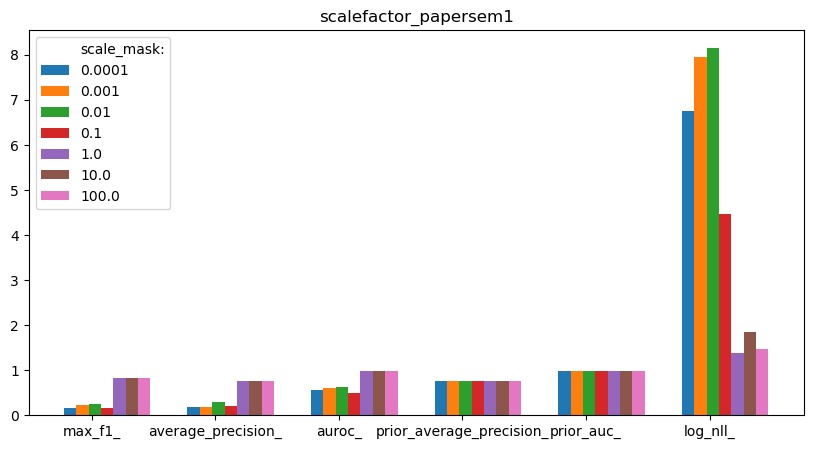

In [20]:
width = 0.1
a = 0.005
x = np.arange(means.shape[1])
for i,row in means.iterrows():
    y = row.values
    plt.bar(x = x, height = y, label = row.name, width=width)
    if not "log_nll_" in means.columns:
        plt.errorbar(x = x, y = y, c = "black", yerr=stds.loc[i], fmt="none")
    x = x + width
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.title(f"{experiment}")
xticks = np.array(plt.xticks()[0])
a = 0.05
#for m, metric in enumerate(means.columns):
#    bar_height = 0
#    scores = means[metric]
#    for c1, _ in enumerate(scores):
#        y1 = params.query(f"{param_of_interest} == '{scores.index[c1]}'")[metric].apply(np.array)
#        print(c1, y1)
#        for c2, _ in enumerate(scores):
#            y2 = params.query(f"{param_of_interest} == '{scores.index[c2]}'")[metric].apply(np.array)
#
#            if c1 >= c2:
#                # continue when comparing same row
#                continue
#            print(c2, y2)
#            p = np.round(ttest_rel(y1, y2).pvalue, 5)
#            print(f"p value of: {metric} in {scores.index[c1]} vs {scores.index[c2]} is {p}")
#            if p>a:
#                # continue if not significant
#                continue
#            y_bar1 = np.max([y1, y2]) *(1.1+bar_height*0.2)
#            y_bar2 = y_bar1 +0.1
#            x1 = xticks[c1+1+m*len(scores)]
#            x2 = xticks[c1+1+m*len(scores)]+width
#            plt.plot(np.repeat([x1, x2], 2), np.array([y_bar1, y_bar2])[[0,1,1,0]], c = "black")
#            y_text = y_bar2 +0.1
#            x_text = np.mean([x1, x2])
#            plt.ylim((0, y_text*1.1))
#            p = f"p value: {p}"
#            plt.text(x = x_text, y = y_text, s = p, ha="center")
#            bar_height += 1
#            #plt.ylim((0, y_text*1.2))
plt.plot([], [], " ", label = param_of_interest + ":")
plt.legend()
plt.xticks(ticks = np.arange(means.shape[1]) + width*(0.25*len(means)), labels=means.columns)
if save:
    path = Path(f"./presentation/{experiment}_newmetrics_bar.pdf")
    print(f"saving to: {path}")
    plt.savefig(path)
    params.to_csv(path.parent/f"{experiment}_newmetrics_bar.csv")

In [136]:
len(model.test_gene_ko)

21

/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


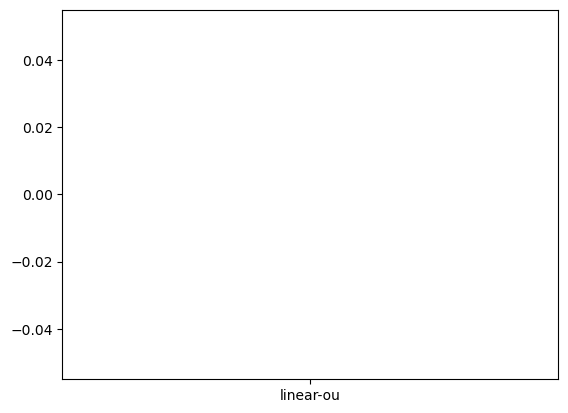

Text(0, 0.5, 'Log-NLL')

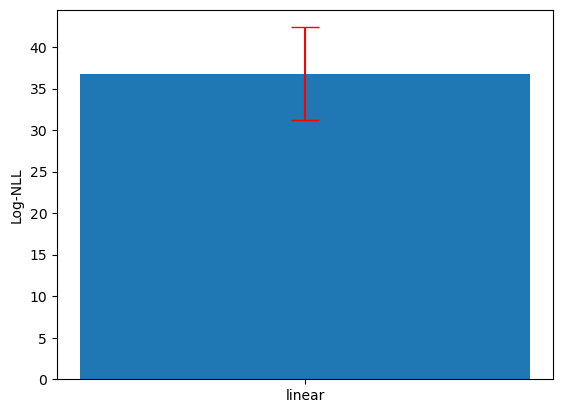

In [5]:
# plot figures from paper
# extract from np tuple
pattern = re.compile("(?<=\()\d+\.*\d+(?=\))")
# Sem1:
config = "linear-ou"
nll = params.query(f'data_sem == "{config}"')["nll"]
means = nll.map(lambda x: float(re.findall(pattern, x)[0]))
errors = nll.map(lambda x: float(re.findall(pattern, x)[1]))
mean = np.mean(means)
error = np.sqrt(np.square(errors).sum())
error = np.std(means)
plt.bar(x = config, height=mean)
plt.errorbar(x=config, y= mean, yerr=error, fmt="none",c = "red", capsize=10)
plt.show()
config = "linear"
nll = params.query(f'data_sem == "{config}"')["nll"]
means = nll.map(lambda x: float(re.findall(pattern, x)[0]))
errors = nll.map(lambda x: float(re.findall(pattern, x)[1]))
mean = np.mean(means)
error = np.sqrt(np.square(errors).sum())
error = np.std(means)
plt.bar(x = config, height=mean)
plt.errorbar(x=config, y= mean, yerr=error, fmt="none",c = "red", capsize=10)

plt.ylabel("Log-NLL")

In [46]:
# transform functions
pdt = torch.distributions.PositiveDefiniteTransform()
def mat_prod(m):
    # performs very badly
    return torch.matmul(m, m.T)
def cholesky(m):
    transform = torch.distributions.LowerCholeskyTransform()
    m_t = transform(m)
    return m_t + m_t.T
t_func = [pdt, cholesky]

# distribution func
def normal(z_bar, omega):
    return torch.distributions.Normal(loc=z_bar, scale = torch.sqrt(torch.diag(omega)))
def mvn(z_bar, omega):
    return torch.distributions.MultivariateNormal(loc=z_bar, covariance_matrix=omega)
dists = [normal, mvn]
configs = [
    {
    "compare_latents":False,
    "latents_sampled":False,
    "omega_transform":None,
    "dist":None
    },
    {
    "compare_latents":True,
    "latents_sampled":True,
    "omega_transform":pdt,
    "dist":normal,
    }
]
configs2 = [
    {
    "compare_latents":False,
    "latents_sampled":False,
    "omega_transform":None,
    "dist":None
    },
    {
    "compare_latents":False,
    "latents_sampled":False,
    "omega_transform":pdt,
    "dist":normal,
    }
]

In [ ]:
SEED = 1
iterator = [0, 1]
validation_size = 0
batch_size = 10000
scores = np.empty((len(ckpts.keys()), len(iterator)))
for k, (key, model) in enumerate(ckpts.items()):
    print(key)
    
    for n,i in enumerate(iterator):
        print(f"Iterator state: {i}")
        scores[k,n] = evaluate_model(model, key=key, models_path=models_path, max_epochs = 1000, compute_class_metrics = False, **configs[i])[0]


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


run_062
Iterator state: 0
GT_INTERV.DEVICE: cpu
setting device to: cpu


/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=1000000). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  

Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
Iterator state: 1
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.55 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.54 seconds
run_065


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Iterator state: 0
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.40 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
Iterator state: 1
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.45 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.48 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
run_064
Iterator state: 0
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.36 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.36 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.36 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.36 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.36 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.36 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.36 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.36 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.37 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.36 seconds
Iterator state: 1
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.57 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.70 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.70 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.70 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.70 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.70 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.70 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.70 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.70 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.59 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.54 seconds
run_061


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Iterator state: 0
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
Iterator state: 1
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.54 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.53 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.54 seconds
run_063


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Iterator state: 0
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
Iterator state: 1
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.46 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.69 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.69 seconds


Text(0.5, 1.0, 'Selection Summary')

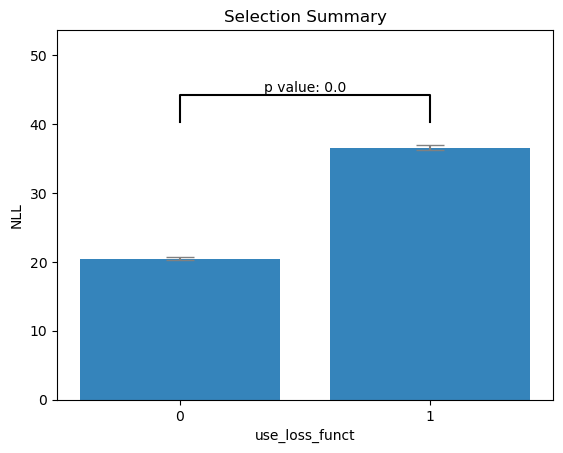

In [57]:
y = np.mean(scores, axis = 0)
x=np.array(iterator).astype(str)
plt.bar(x=x, height=y, alpha = 0.9)
plt.errorbar(x=x, y=y,yerr=np.std(scores, axis = 0), fmt="none", c = "grey", capsize=10)
xticks = np.array(plt.xticks()[0])
a = 0.01
n_sign = 0
# enumerate pairs and test for significance
for c1 in range(scores.shape[1]):
    for c2 in range(scores.shape[1]):
        if c1 >= c2:
            # continue when comparing same column
            continue
        p = np.round(ttest_rel(scores[:,c1], scores[:,c2]).pvalue, 5)
        if p>a:
            # continue if not significant
            continue
        y_bar1 = np.max(y) *(1.1+n_sign*0.2)
        y_bar2 = y_bar1 *1.1
        plt.plot(np.repeat(xticks[[c1, c2]], 2), np.array([y_bar1, y_bar2])[[0,1,1,0]], c = "black")
        y_text = y_bar2 *1.01
        x_text = np.mean(xticks[[c1, c2]])
        plt.ylim((0, y_text*1.1))
        p = f"p value: {p}"
        plt.text(x = x_text, y = y_text, s = p, ha="center")
        n_sign += 1
        plt.ylim((0, y_text*1.2))
plt.xlabel("use_loss_funct")
plt.ylabel("NLL")
plt.title("Selection Summary")
#plt.legend()
#plt.savefig(Path(f"./presentation/NLL_{experiment}_SEM2_lossfunct.pdf"))

run_062
Iterator state: 1
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.


Training took 0.00 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.00 seconds
Iterator state: 10
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reac

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: F

Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
Iterator state: 100
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
Iterator state: 1000
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.


Training took 0.39 seconds
run_065
Iterator state: 1
More than 20 test_genes! Removing last 1 contexts.
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.00 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.00 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.00 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.


Training took 0.00 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.00 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.00 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.00 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reac

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reac

Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
Iterator state: 100
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100`

Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False


Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.04 seconds
Iterator state: 1000
More than 20 test_genes! Removing last 1 contexts.
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.39 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.39 seconds
run_064
Iterator state: 1
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.


GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.


Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
Iterator state: 10
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reac

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: F

Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
Iterator state: 100
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, usin

Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
Iterator state: 1000
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.42 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.


Training took 0.38 seconds
run_061
Iterator state: 1
More than 20 test_genes! Removing last 1 contexts.
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.


Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device 

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reac

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 

Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
Iterator state: 100
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
Iterator state: 1000
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.41 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.38 seconds
run_063
Iterator state: 1
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.


GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 

IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.


Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
Iterator state: 10
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reac

GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 

Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
Iterator state: 100
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, usin

Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.05 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100`

Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=100` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=100` reached.


Training took 0.04 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.04 seconds
Iterator state: 1000
More than 20 test_genes! Removing last 1 contexts.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.41 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.38 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1000` reached.


Training took 0.39 seconds


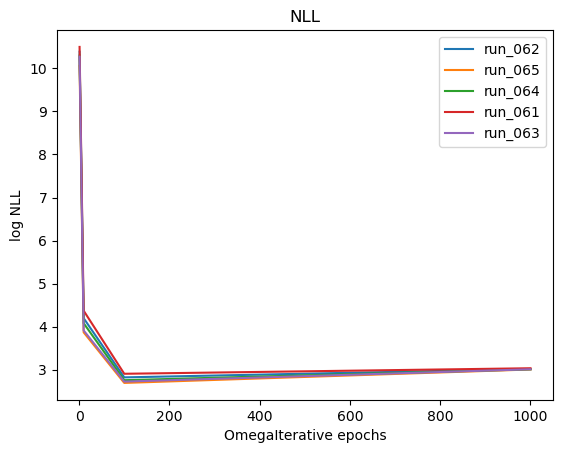

In [44]:
SEED = 1
iterator = np.power(10, np.arange(4), dtype=int)
validation_size = 0
batch_size = 10000
scores = np.empty((len(ckpts.keys()), len(iterator)))
for k, (key, model) in enumerate(ckpts.items()):
    print(key)
    
    for n,i in enumerate(iterator):
        print(f"Iterator state: {i}")
        nll = evaluate_model(model, key=key, models_path=models_path, max_epochs = int(i), compute_class_metrics = False, **configs[0])[0]
        scores[k,n] = nll
    plt.plot(iterator, np.log(scores[k]), label=key)
plt.xlabel("OmegaIterative epochs")
plt.ylabel("log NLL")
plt.title("NLL")
plt.legend()

In [45]:
scores

array([[3.24010996e+04, 6.65615387e+01, 1.68354759e+01, 2.04094524e+01],
       [2.33152090e+04, 4.79202652e+01, 1.48045321e+01, 2.02329445e+01],
       [2.96352559e+04, 5.92403564e+01, 1.57722778e+01, 2.03184776e+01],
       [3.61837578e+04, 7.92323227e+01, 1.83092270e+01, 2.08166008e+01],
       [2.88507383e+04, 5.01069565e+01, 1.52658892e+01, 2.03208847e+01]])

In [53]:
SEED = 1
iterator = np.power(10, np.arange(4))
cols = ["nll"]
validation_size = 0
batch_size = 10000
for key, model in ckpts.items():
    scores = pd.DataFrame(columns=cols)
    samples = torch.tensor(np.load(models_path/key/"synthetic_data"/"check_sim_samples.npy"))
    sim_regime = torch.tensor(np.load(models_path/key/"synthetic_data"/"check_sim_regimes.npy"))
    beta = torch.tensor(np.load(models_path/key/"synthetic_data"/"check_sim_beta.npy"))
    train_gene_ko = model.train_gene_ko
    test_gene_ko = model.test_gene_ko
    train_loader, validation_loader, test_loader = create_loaders(
        samples=samples, # test_loader is None
        sim_regime=sim_regime,
        validation_size=validation_size,
        batch_size=batch_size,
        SEED= SEED,
        train_gene_ko=train_gene_ko,
        test_gene_ko=test_gene_ko,
        persistent_workers=False,
        covariates=None,
        num_workers= 1,
    )

    for n in iterator:
        print(n)
        scores.loc[len(scores)] = [model.evaluate(test_loader.dataset, compare_latents=False, max_epochs = int(n))][0]
    plt.plot(iterator, np.log(scores), label=key)
    break
plt.xlabel("OmegaIterative epochs")
plt.ylabel("log NLL")
plt.title("NLL")
plt.legend()

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 64 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/data/toulouse/miniforge3/envs/bicycle/lib/python3.11/site-packages/pytorch_lightning/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller

1
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu


`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds
GT_INTERV.DEVICE: cpu
setting device to: cpu
Training took 0.01 seconds


ValueError: cannot set a row with mismatched columns

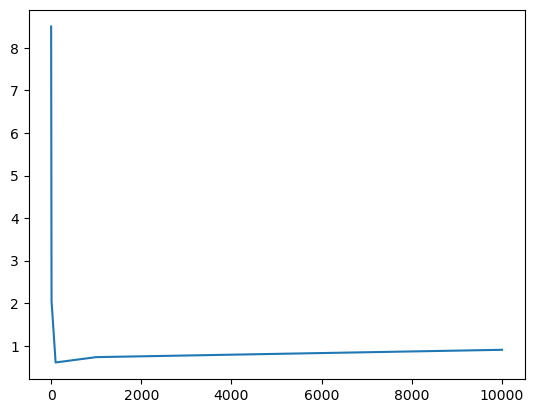

In [8]:
nll = scores
nll = nll.map(lambda x: x[0])
plt.plot(iterator, np.log(nll))
plt.show()

In [9]:
nll

,nll
0,4925.346680
1,7.784485
2,1.835296
3,2.081092
4,2.471947


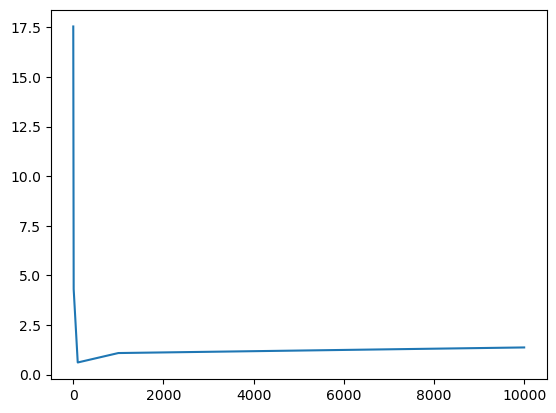

In [ ]:
nll = scores
nll = nll.map(lambda x: x[0])
plt.plot(iterator, np.log(nll))
plt.show()

In [11]:
nll

,nll
0,4.178623e+07
1,7.419907e+01
2,1.840937e+00
3,2.961784e+00
4,3.927456e+00


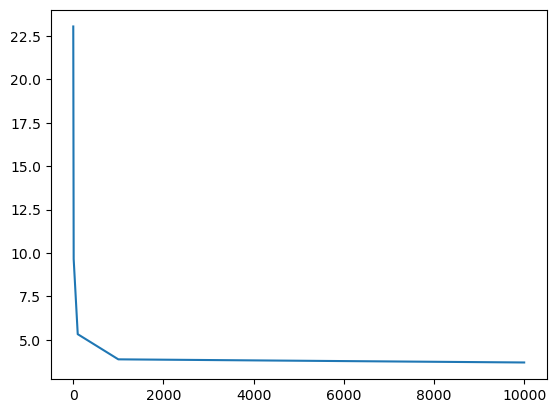

In [32]:
nll = scores["nll"]
nll = nll.map(lambda x: x[0])
plt.plot(iterator, np.log(nll))
plt.show()

In [18]:
nll

0    9.610263e+09
1    1.578650e+04
2    2.064249e+02
3    4.771230e+01
Name: nll, dtype: float32

In [ ]:
def unseen_nll(model:BICYCLE,
               unseen_contexts:list, # list of target gene indexes for each sample
               unseen_data_csv:Path, # path to samples # at least samples_per_pert for each context
               samples_per_pert:int = 5, 
               target_mu=[],
               target_std=[],
               ):
    if target_mu is []:
        target_mu = np.median(model.alpha_p.detach().numpy())
    if target_std is []:
        target_std = np.median(model.sigma_p.detach().numpy())
    # read data
    samples = pd.read_csv(unseen_data_csv, index_col=0)

    contexts= list(set(unseen_contexts))
    sample_target_idxs = [unseen_contexts.index(c) for c in contexts]
    print(contexts)
    nlls = []
    for n, targets in enumerate(contexts):
        if targets == np.nan:
            continue
        if not type(targets) is list:
            targets = [targets]
        target_samples = torch.tensor(samples.iloc[sample_target_idxs[n]:sample_target_idxs[n]+samples_per_pert].to_numpy())
        z_bar, omega = model.predict_perturbation(
            target_idx = [*targets], # target index in genes
            target_mu=target_mu,
            target_std=target_std,
            max_epochs=5000,
            perturbation_type=[],
            perturbation_like=[],
            )

        nll = model.test_nll(
            z_bar = z_bar+torch.abs(z_bar.min()),
            omega = omega,  # var = scale**2
            samples = target_samples,
            )

        nlls.append(nll)
    return nlls


key = "run_042"
data_id = params.loc[key, "data_id"]
model = ckpts[key].to("cpu")
samples_per_pert=10
#with open(data_path/data_id/"unseen_target_genes.json", "r") as rf:
#    target_genes = json.load(rf)
if params.loc[key, "data_source"] == "scMultiSim":
    adata = sc.read_h5ad(data_path/"scMultiSim_data"/params.loc[key, "data_id"]/"ready_full_rna.h5ad",)
    samples = adata.X.copy()
    TFs = np.arange(10)
    target_genes = np.repeat(TFs, 400)
    target_genes = np.concatenate([np.full((8000),np.nan), target_genes])
    mask = np.isnan(target_genes)
    samples = samples[~mask]
    unseen_contexts = target_genes[~mask]
else:
    samples = np.load(models_path/key/"synthetic_data"/"check_sim_samples.npy")
    sim_regime = np.load(models_path/key/"synthetic_data"/"check_sim_regimes.npy")
    gt_interv = np.load(models_path/key/"synthetic_data"/"check_sim_gt_interv.npy")
    contexts = gt_interv[:,sim_regime].astype(bool).T
    gene_idxs = np.arange(samples.shape[1])
    target_genes = [tuple(gene_idxs[c]) for c in contexts if c.any()]
    samples = samples[-len(target_genes):]
(data_path/"/tmp").mkdir(exist_ok=True)
pd.DataFrame(samples).to_csv(data_path/"tmp"/"samples.csv")
nlls= unseen_nll(model=model,
           unseen_contexts=target_genes,
           unseen_data_csv=data_path/"tmp"/"samples.csv",
           samples_per_pert=samples_per_pert,
           target_mu=[0.1],
           target_std=[0.2]
           )

plt.hist(nlls)


In [ ]:
key = "run_055"
data_id = params.loc[key, "data_id"]
model = ckpts[key].to("cpu")
samples_per_pert=1

target_genes = np.load(data_path/data_id/"unseen_target_genes.npy")
unseen_data_csv = data_path/data_id/"unseen_rna_matrix.csv"

nlls= unseen_nll(model=model,
           unseen_contexts=target_genes,
           unseen_data_csv=unseen_data_csv,
           samples_per_pert=samples_per_pert,
           target_mu=[0.1],
           target_std=[0.2]
           )

plt.hist(nlls)


In [ ]:
key = "run_042"
model = ckpts[key].to("cpu")

target_idx = 0
grn = model.gt_beta.numpy().copy()
if params.loc[key, "data_source"] == "scMultiSim":
    adata = sc.read_h5ad(data_path/"scMultiSim_data"/params.loc[key, "data_id"]/"ready_full_rna.h5ad",)
    samples = adata.X.copy()
    samples = samples[8000 + (400*target_idx):8400+(400*(target_idx+1))]
else:
    samples = np.load(models_path/key/"synthetic_data"/"check_sim_samples.npy")
    print("samples: shape",samples.shape)
    sim_regime = np.load(models_path/key/"synthetic_data"/"check_sim_regimes.npy")
    gt_interv = np.load(models_path/key/"synthetic_data"/"check_sim_gt_interv.npy")
    contexts = gt_interv[:,sim_regime]    
    samples = samples[np.argmax(contexts, axis=0) == target_idx]

target_mu = np.median(model.alpha_p.detach().numpy())
target_std = np.median(model.sigma_p.detach().numpy())

In [ ]:
z_bar, omega = model.predict_perturbation(target_idx = [target_idx],
    target_mu=[target_mu],
    target_std=[target_std],
    max_epochs=1000,
    perturbation_type=[],
    perturbation_like=[],)

In [ ]:
omega.shape

In [ ]:
nlls = []
for s in torch.tensor(samples):
    nlls.append(model.test_nll(z_bar = z_bar+torch.abs(z_bar.min()),
        omega = omega,
        samples = s))


In [ ]:
plt.hist(nlls, bins=50, density=True)
print(np.std(nlls))
print(np.mean(nlls))